In [1]:
import os
import glob
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense 
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
import tensorflow.keras.preprocessing.image 
import cv2
import matplotlib.pyplot as plt

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9924869013113442357
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2117446860
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6241525878904120336
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


In [3]:
path = "E:\deep learning project\inaturalist_12K"

In [4]:
def get_data(path,augmentation=True):
    train_path=os.path.join(path,"train")
    test_path=os.path.join(path,"val")
    if augmentation==False:
        train_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=0.1)
    else:
        train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                          rotation_range=90,
                                                                          zoom_range=0.2,
                                                                          shear_range=0.2,
                                                                          validation_split=0.1,
                                                                          horizontal_flip=True)
    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    train_data = train_generator.flow_from_directory(directory=train_path,
                                                     target_size=(256, 256),
                                                     color_mode="rgb",
                                                     batch_size=32,
                                                     class_mode="categorical",
                                                     shuffle=True,
                                                     seed=42)
    valid_data = train_generator.flow_from_directory(directory=train_path,
                                                     target_size=(256, 256),
                                                     color_mode="rgb",
                                                     batch_size=32,
                                                     class_mode="categorical",
                                                     shuffle=True,
                                                     seed=42)
    test_data=test_generator.flow_from_directory(directory=test_path,
                                                 target_size=(256, 256),
                                                 color_mode="rgb",
                                                 batch_size=32,
                                                 class_mode="categorical",
                                                 shuffle=True,
                                                 seed=42)
    return train_data,valid_data,test_data

In [5]:
image_size=256
output_size=10

In [6]:
from wandb.keras import WandbCallback
class CNN(object):
    def __init__(self, no_conv_layers, kernel_size, learning_rate,
                 epochs,padding, filter_no_metric, dense_layer_size=32,
                 activation_func='relu', no_filters=32, image_size=256,
                 drop_out=0.2,output_size=10, augmentation= True, 
                 batch_normalization=True):
        self.kenel_size = kernel_size
        self.learning_rate = learning_rate
        self.image_size = image_size
        self.output_size = output_size
        self.augmentation = augmentation
        self.batch_normalization = batch_normalization
        self.no_conv_layers = no_conv_layers
        self.dense_layer_size = dense_layer_size
        self.drop_out = drop_out
        self.no_filters = no_filters
        self.epochs = epochs
        self.padding = padding
        self.filter_no_metric = filter_no_metric
        self.activation_func = activation_func
        self.initialize(no_conv_layers, kernel_size, learning_rate,
                        epochs,padding, filter_no_metric, dense_layer_size,
                        activation_func, no_filters, image_size, drop_out,
                        output_size, augmentation, batch_normalization)

    def initialize(self, no_conv_layers, kernel_size, learning_rate,
                   epochs, padding, filter_no_metric, dense_layer_size=32,
                   activation_func='relu', no_filters=32, image_size=256,
                   drop_out=0.2, output_size=10, augmentation=True,
                   batch_normalization=True):
        self.model=Sequential()
        for i in range(0,no_conv_layers):
            if i==0:
                self.model.add(Conv2D(no_filters, kernel_size,
                                      input_shape=(image_size, image_size, 3),
                                      kernel_initializer = "he_uniform",
                                      padding = padding,
                                      data_format="channels_last"))
            else:
                if filter_no_metric=="1":
                    self.model.add(Conv2D(no_filters, kernel_size, kernel_initializer="he_uniform", padding=padding))
                elif filter_no_metric=="2":
                    self.model.add(Conv2D(no_filters*(2**i),kernel_size,
                                          kernel_initializer="he_uniform",
                                          padding=padding))
                elif filter_no_metric=="1/2":
                    self.model.add(Conv2D(no_filters*(1/(2**i)), kernel_size,
                                          kernel_initializer="he_uniform",
                                          padding=padding))

            self.model.add(Activation(activation_func))
            if batch_normalization==True:
                self.model.add(BatchNormalization())
            self.model.add(MaxPooling2D(pool_size=(2,2)))
        if batch_normalization==True:
            self.model.add(BatchNormalization())
        self.model.add(Flatten())
        self.model.add(Dense(dense_layer_size))
        self.model.add(Activation(activation_func))
        if batch_normalization==True:
            self.model.add(BatchNormalization())
        self.model.add(Dropout(drop_out))
        self.model.add(Dense(output_size))
        self.model.add(Activation("softmax"))

In [8]:
import numpy as np
from tensorflow.keras.optimizers import Adam
np.random.seed(2)
classes=["Amphibia", "Animalia", "Arachnida", "Aves", "Fungi", "Insecta", "Mammalia", "Mollusca", "Plantae", "Reptilia"]
train_data, valid_data, test_data= get_data(path, False)
best_model=CNN(5, (4,4),0.001, 10, 'same', '1',128, 'selu',
              32, image_size, 0.4, output_size,False, True)
best_model.model.compile(optimizer=Adam(0.001),  # Optimizer
                         loss="categorical_crossentropy",
                         metrics="categorical_accuracy")
best_model.model.fit(train_data, epochs=10, batch_size=64, validation_data=valid_data)

Found 9999 images belonging to 10 classes.
Found 9999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.
Epoch 1/10
313/313 [==============================] - 424s 1s/step - loss: 2.4424 - categorical_accuracy: 0.2149 - val_loss: 2.0307 - val_categorical_accuracy: 0.2868
Epoch 2/10
313/313 [==============================] - 411s 1s/step - loss: 2.0996 - categorical_accuracy: 0.2858 - val_loss: 2.0638 - val_categorical_accuracy: 0.2924
Epoch 3/10
313/313 [==============================] - 428s 1s/step - loss: 1.9648 - categorical_accuracy: 0.3188 - val_loss: 1.8137 - val_categorical_accuracy: 0.3643
Epoch 4/10
313/313 [==============================] - 427s 1s/step - loss: 1.8480 - categorical_accuracy: 0.3544 - val_loss: 1.7250 - val_categorical_accuracy: 0.4058
Epoch 5/10
313/313 [==============================] - 415s 1s/step - loss: 1.7662 - categorical_accuracy: 0.3853 - val_loss: 1.7460 - val_categorical_accuracy: 0.3882
Epoch 6/10
313/313 [================

In [9]:
best_model.model.evaluate(test_data, batch_size=256)

63/63 [==============================] - 45s 714ms/step - loss: 1.9404 - categorical_accuracy: 0.3715


[1.9403777122497559, 0.3714999854564667]

In [43]:
best_model.model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 256, 256, 32)      1568      
_________________________________________________________________
activation_7 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 128, 128, 32)      16416     
_________________________________________________________________
activation_8 (Activation)    (None, 128, 128, 32)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 128, 128, 32)     

In [94]:
gb_model.layers
#best_model.model.layers[16].output


In [95]:
gb_model = tf.keras.models.Model(inputs = [best_model.model.inputs], outputs = [best_model.model.layers[16].output])

In [55]:
@tf.custom_gradient
def guidedRelu(x):
    def grad(dy):
        return tf.cast(dy>0,tf.float32)  * tf.cast(x>0,tf.float32) * dy
    return tf.nn.relu(x), grad


layer_dict = [layer for layer in gb_model.layers if hasattr(layer,'activation')]
for layer in layer_dict:
    if layer.activation == tf.keras.activations.relu:
        layer.activation = guidedRelu

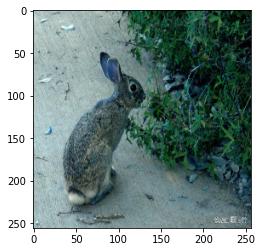

In [93]:
image_path = "E:\deep learning project\inaturalist_12K/train/Mammalia/004d9943d3a1ce516b94d25df16ce19d.jpg"
image = cv2.imread(image_path)
image = cv2.resize(image,(256,256))
image = image/255
plt.imshow(image)

In [83]:
import wandb

In [84]:
wandb.login()

wandb: Currently logged in as: akashsainics21m003 (use `wandb login --relogin` to force relogin)


True

In [85]:
wandb.init(project="guided_backprop", entity="cs21m003_cs21d406")

In [86]:
def norm_flat_image(img):
    grads_norm = img[:,:,0]+ img[:,:,1]+ img[:,:,2]
    grads_norm = (grads_norm - tf.reduce_min(grads_norm))/ (tf.reduce_max(grads_norm)- tf.reduce_min(grads_norm))
    return grads_norm

(16, 16, 32)


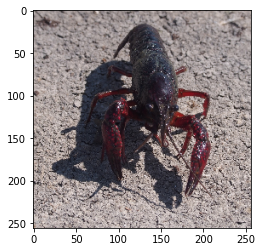

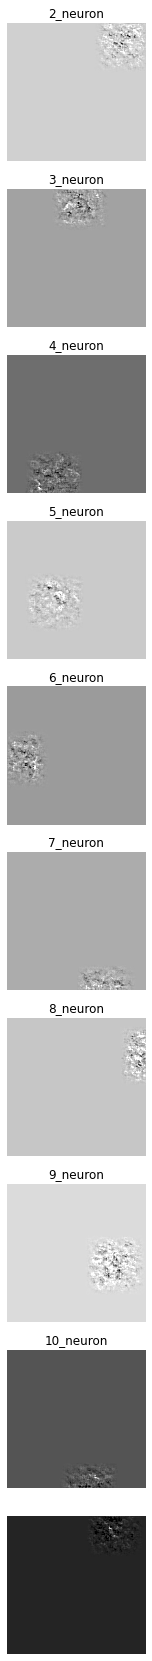

In [92]:
image=test_data[0][0][12]
plt.imshow(image)
wandb.init(project="guided_backprop", entity="cs21m003_cs21d406")
wandb.log({"true_image":plt})
image = cv2.resize(image,(256,256))
image = image/255
input_img = image
input_img = tf.expand_dims(image, axis=0)
output_shape = best_model.model.layers[16].output.shape[1:]
print(output_shape)
#output_shape=best_model.model.get_layer('conv2d_9').output.shape[1:]
plt.figure(figsize=(30,30))
for pt in range(10):
    idx = np.random.randint(0, output_shape[0])
    idy = np.random.randint(0, output_shape[1])
    idz = np.random.randint(0, output_shape[2])

    mask = np.zeros((1, *output_shape), dtype="float")
    mask[0, idx, idy, idz] = 1.0
    with tf.GradientTape() as tape:
        tape.watch(input_img)
        result=gb_model(input_img) * mask
    grads = tape.gradient(result,input_img)[0]
    plt.title(str(pt+1)+"_neuron")
    normalized_grads = norm_flat_image(grads)
    plt.subplot(10, 1, pt+1)
    plt.imshow(normalized_grads, vmin=0.3, vmax=0.7,cmap="gray")
    plt.axis("off")
wandb.log({"neurons":plt})

In [97]:

save_model = "./guide_prop.h5"
best_model.model.save(save_model)
